<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 27.53 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 11.6 MB/s eta 0:00:00


In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00


In [4]:
from __future__ import annotations
import random, math, torch, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [5]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)


In [6]:
def set_seed(seed, deterministic=False):
  torch.use_deterministic_algorithms(deterministic)
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

In [7]:
x, y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b):b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size =ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

def cnn_layers():
  return [
      conv(1, 8, ks=5),
      conv(8, 16),
      conv(16, 32),
      conv(32, 64),
      conv(64, 10, act=False),
      nn.Flatten(),
  ]

In [9]:
from torcheval.metrics import MulticlassAccuracy

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [11]:
def fit(model, epochs=1, xtra_cbs=None):
  learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
  learn.fit(epochs)
  return learn

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


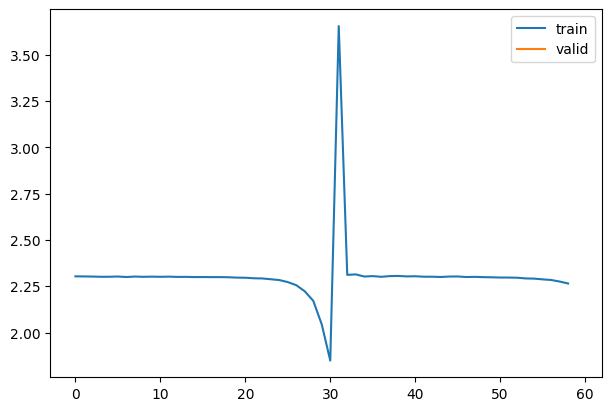

In [12]:
set_seed(42)
learn = fit(nn.Sequential(*cnn_layers()))

In [13]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds = [[] for _ in layers]

  def __call__(self, x):
    for i,l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(to_cpu(x).mean())
      self.act_stds[i].append(to_cpu(x).std())
    return x

  def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


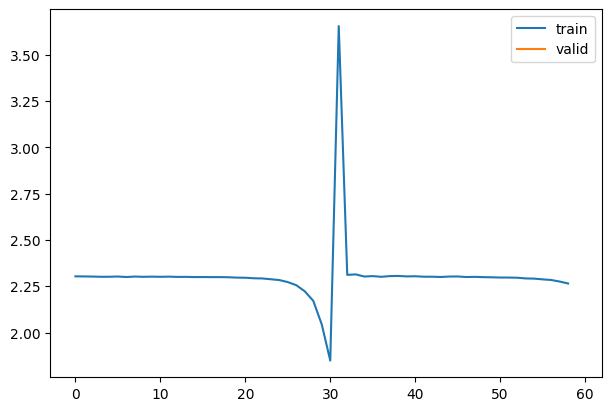

In [14]:
set_seed(42)
model = SequentialModel(*cnn_layers())
learn = fit(model)

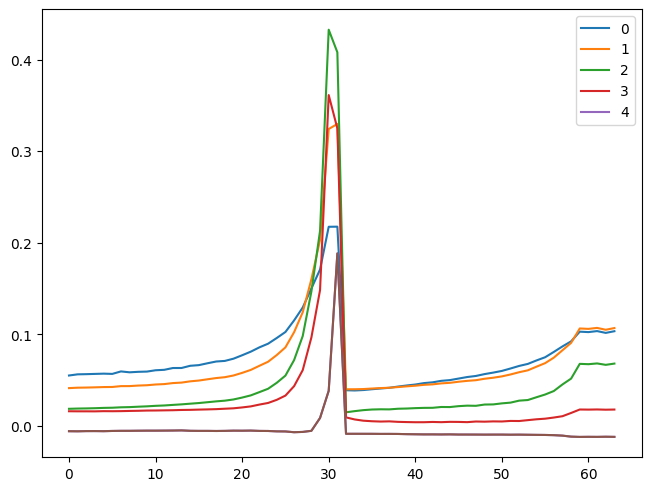

In [15]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

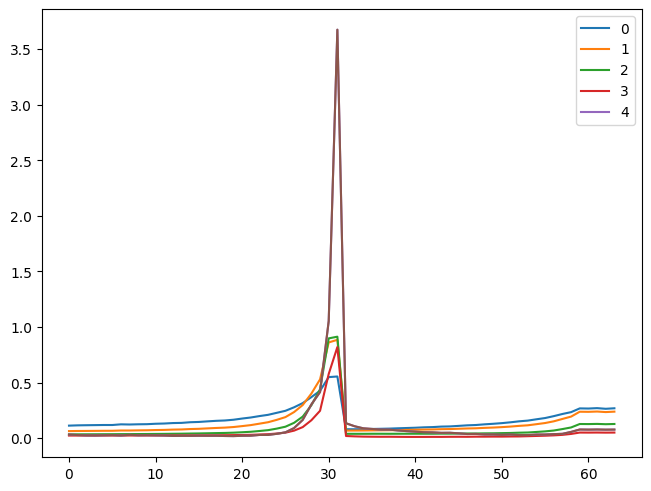

In [16]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

In [17]:
set_seed(42)
model = nn.Sequential(*cnn_layers())

In [18]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [19]:
def append_stats(i, mod, inp, outp):
  act_means[i].append(to_cpu(outp).mean())
  act_stds[i].append(to_cpu(outp).std())

In [20]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


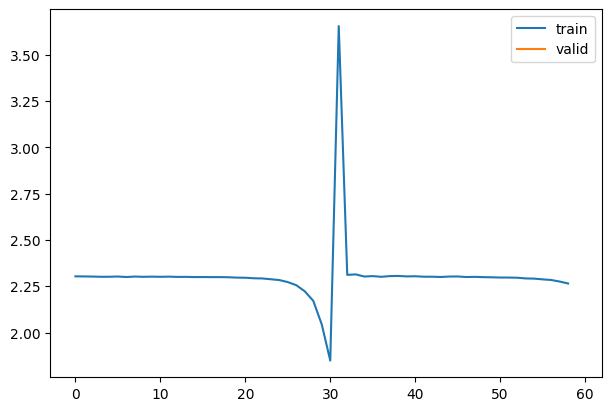

In [21]:
fit(model)

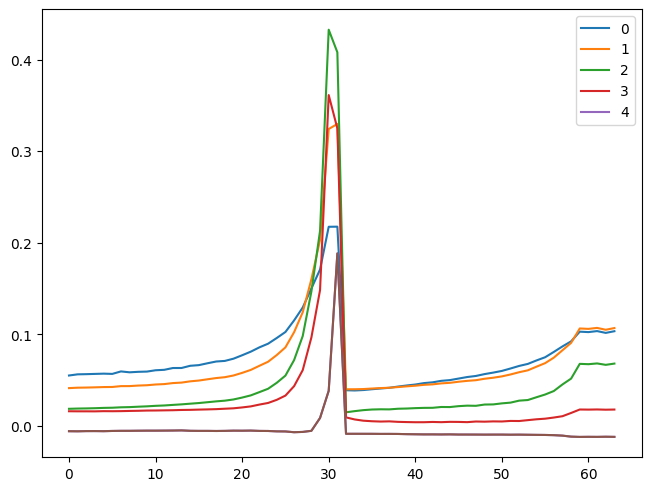

In [22]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

In [23]:
class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def remove(self): self.hook.remove()
  def __del__(self): self.remove()

In [24]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'): hook.stats = ([], [])
  acts = to_cpu(outp)
  hook.stats[0].append(acts.mean())
  hook.stats[1].append(acts.std())

In [25]:
set_seed(42)
model = nn.Sequential(*cnn_layers())

In [26]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


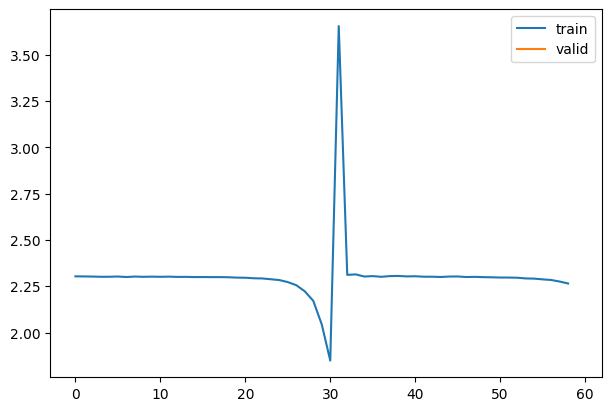

In [27]:
learn = fit(model)

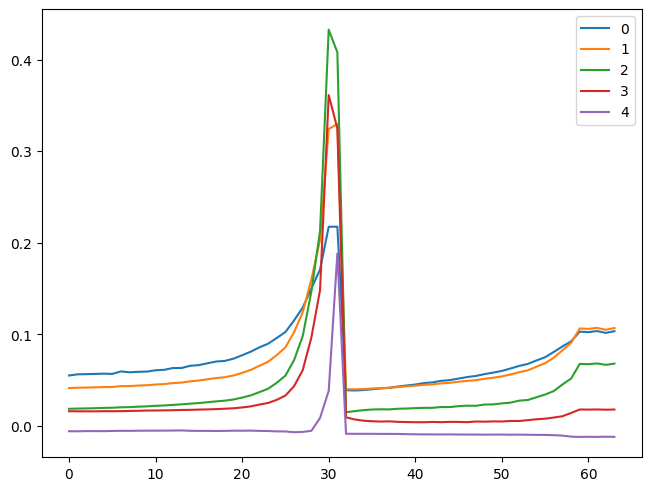

In [28]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()
plt.legend(range(5));

In [29]:
class DummyCtxMgr:
  def __enter__(self, *args):
    print("let's go!")
    return self

  def __exit__(self, *args): print("all done!")
  def hello(self): print("hello.")

In [30]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [36]:
class DummyList(list):
  def __delitem__(self, i):
    print(f"Say bye to item at index {i}")
    super().__delitem__(i)

In [42]:
dml = DummyList([1, 2, 3])
dml

[1, 2, 3]

In [43]:
del(dml[0])

Say bye to item at index 0


In [44]:
dml

[2, 3]

In [45]:
class Hooks(list):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def __del__(self): self.remove()
  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)
  def remove(self):
    for h in self: h.remove()

In [46]:
set_seed(42)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


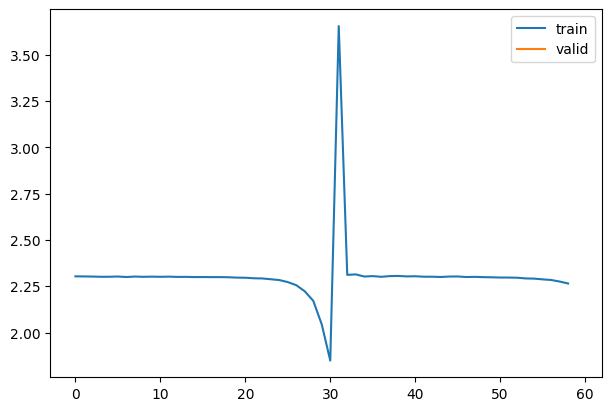

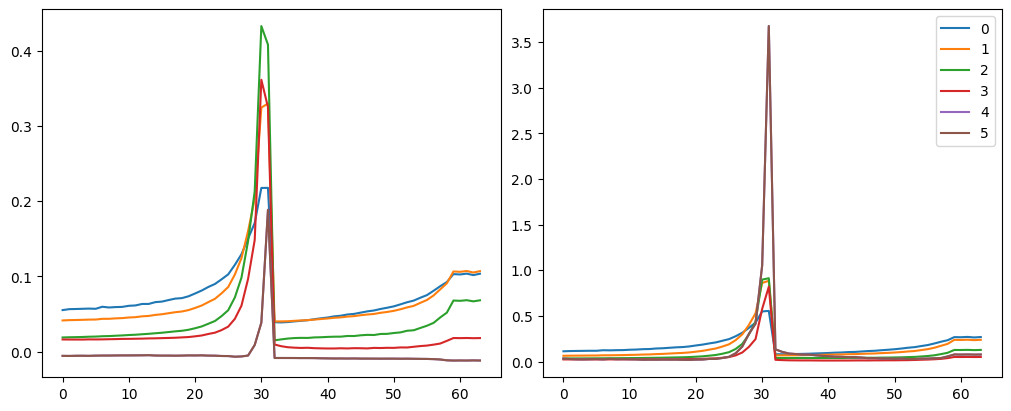

In [47]:
with Hooks(model, append_stats) as hooks:
  fit(model)
  fig, axs = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    for i in 0,1: axs[i].plot(h.stats[i])
  plt.legend(range(6));

In [48]:
class HooksCallback(Callback):
  def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
    fc.store_attr()
    super().__init__()

  def before_fit(self, learn):
    if self.mods: mods = self.mods
    else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
    self.hooks = Hooks(mods, partial(self._hookfunc, learn))

  def _hookfunc(self, learn, *args, **kwargs):
    if (self.on_train and learn.training) or (self.on_valid and not self.training): self.hookfunc(*args, **kwargs)

  def after_fit(self, learn): self.hooks.remove()
  def __iter__(self): return iter(self.hooks)
  def __len__(self): return len(self.hooks)

In [50]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


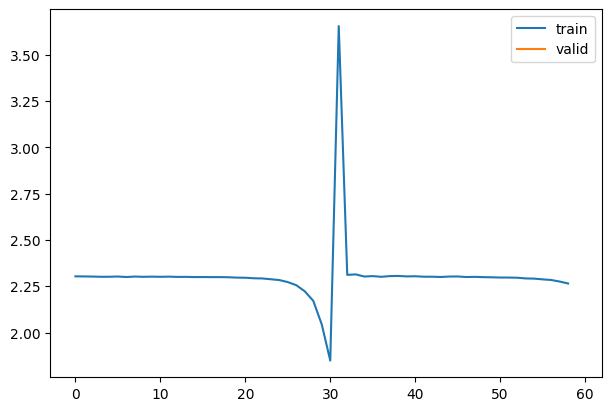

In [51]:
set_seed(42)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

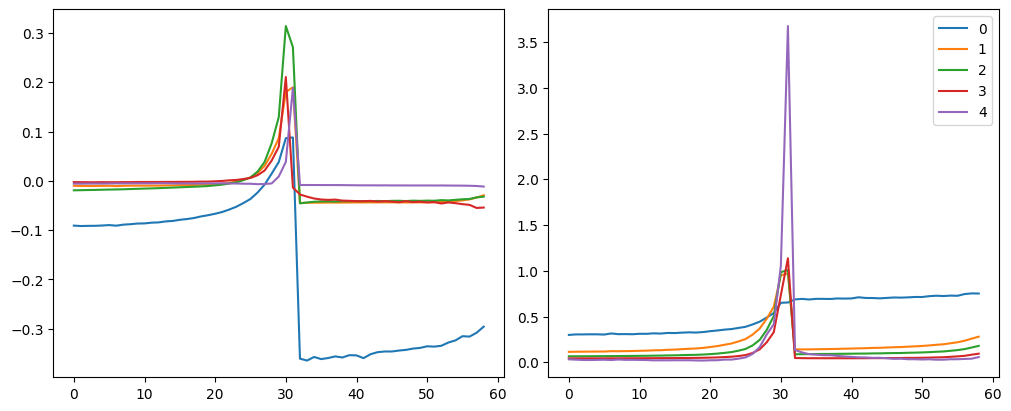

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
  for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

In [53]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
  acts = to_cpu(outp)
  hook.stats[0].append(acts.mean())
  hook.stats[1].append(acts.std())
  hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


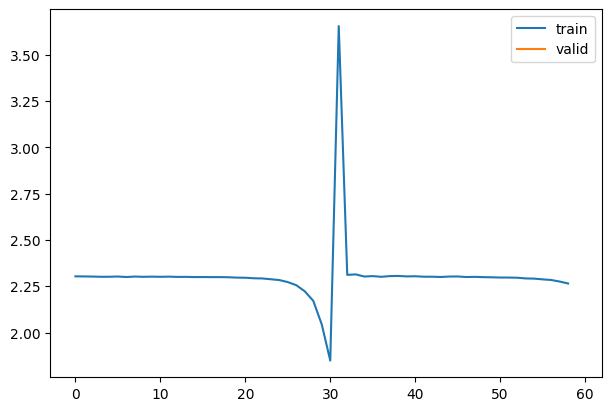

In [54]:
set_seed(42)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [55]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

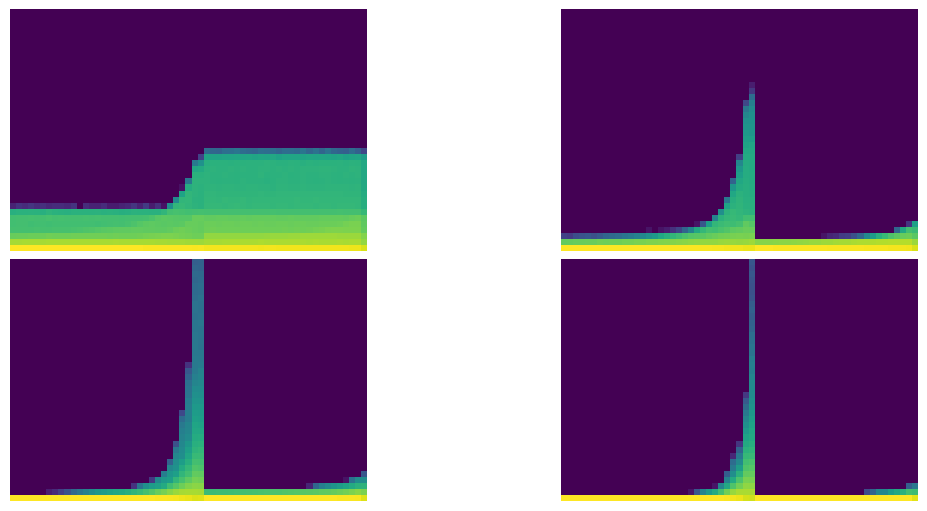

In [56]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flat, hc):
  show_image(get_hist(h), ax, origin='lower')

In [62]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[0]/h1.sum(0)

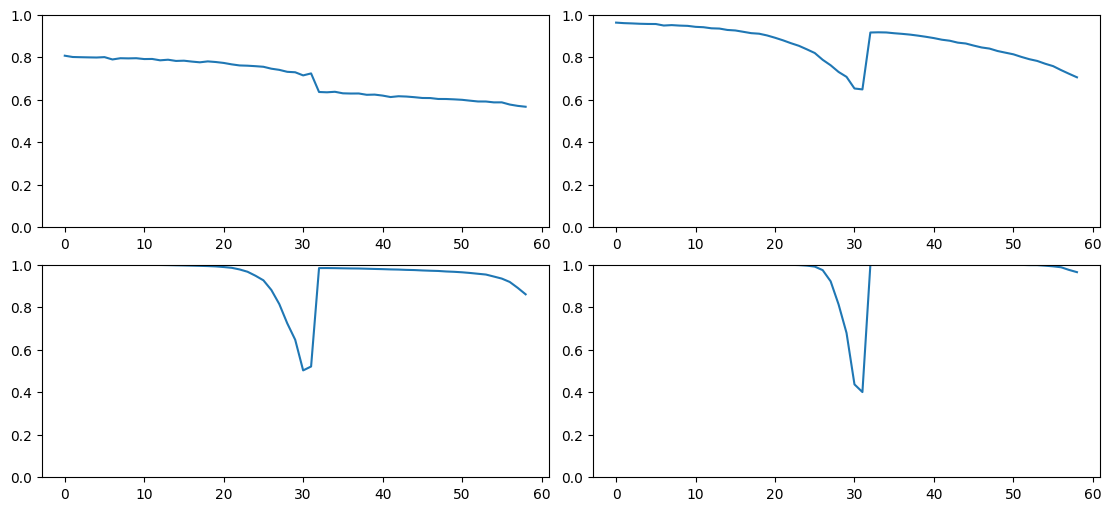

In [64]:
fig, axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
  ax.plot(get_min(h))
  ax.set_ylim(0,1)

In [65]:
class ActivationStats(HooksCallback):
  def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

  def color_dim(self, figsize=(11,5)):
    fig, axes = get_grid(len(self), figsize=figsize)
    for ax, h in zip(axes.flat, self):
      show_image(get_hist(h), ax, origin='lower')

  def dead_chart(self, figsize=(11, 5)):
    fig, axes = get_grid(len(self), figsize=figsize)
    for ax, h in zip(axes.flatten(), self):
      ax.plot(get_min(h))
      ax.set_ylim(0,1)

  def plot_stats(self, figsize=(10, 4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for h in self:
      for i in 0,1: axs[i].plot(h.stats[i])
    axs[0].set_title('Means')
    axs[1].set_title('Stdevs')
    plt.legend(fc.L.range(self))

In [66]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.138,2.305,0,train
0.332,2.248,0,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


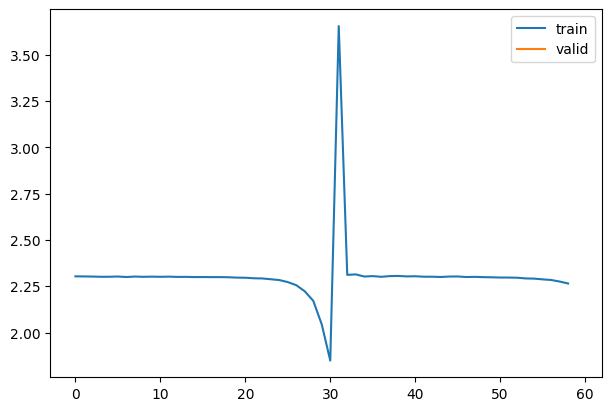

In [67]:
set_seed(42)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

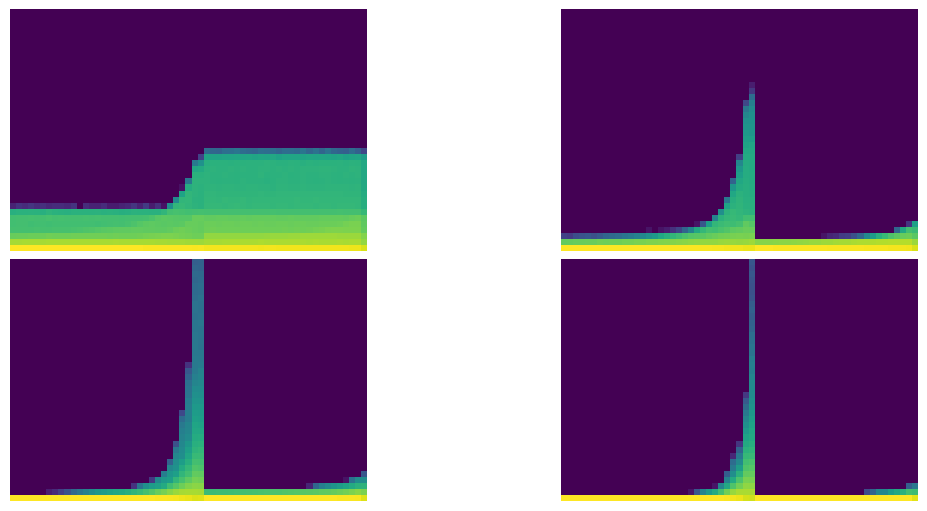

In [68]:
astats.color_dim()

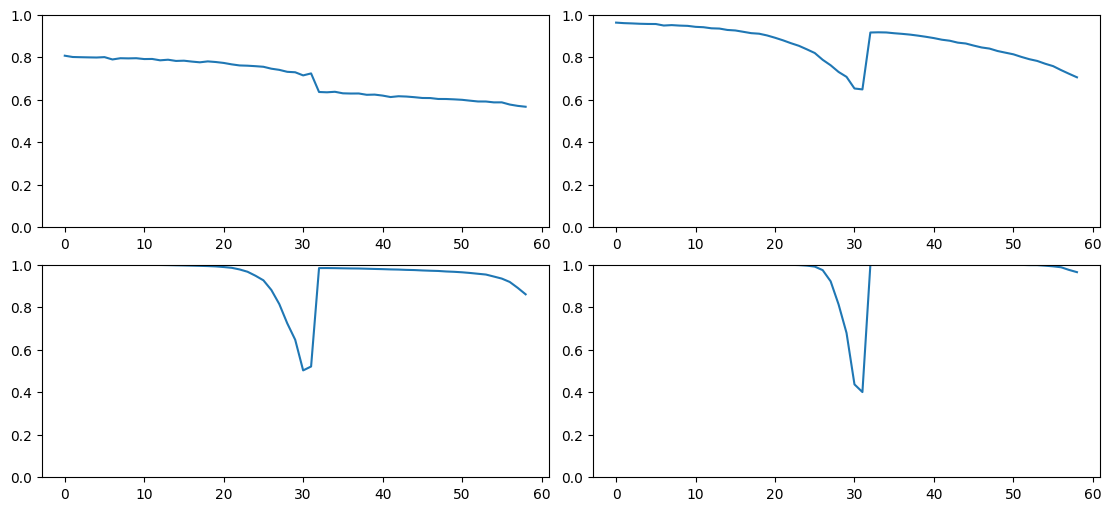

In [69]:
astats.dead_chart()

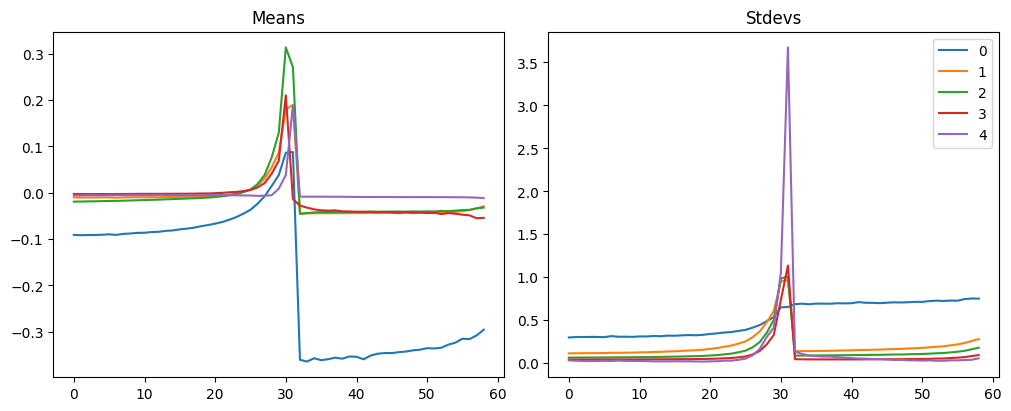

In [70]:
astats.plot_stats()